In [7]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import random 
import scipy as sc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import stormeunice as eun
import matplotlib.transforms as mtransforms
from cmcrameri import cm

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data

In [8]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60

In [9]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='3h').max().load()
era5_PRES = era5_2022.msl.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='3h').max().load()

In [10]:
# EPS
inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
experiments = ['pi', 'curr', 'incr']
eps = {}
for inidate in inidates:
    eps[inidate] = eun.data.Data.get_eps_data(experiments, inidate = inidate)

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2no_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2no_2022-02-14

In [32]:
# analysis
analysis = xr.open_dataset('/home/e/ermis/Storm_Eunice/raw_data/1_2022-02-18_analysis.nc')
analysis_PRES = analysis.msl.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='3h').max().load()

forecast = xr.open_dataset('/home/e/ermis/Storm_Eunice/raw_data/1_2022-02-18.nc')
forecast_GUST = forecast.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='3h').max().load()


# Select extreme and weak ensemble members

In [33]:
composite = False

In [34]:
if composite:
    # box for selecting max wind gusts
    area_for_percentiles = 'full-map'

    full_map = [lon_min, lon_max, lat_min, lat_max]
    south_uk = [-5.7, 1.9, 49.95, 53.40]
    london = [0.12, 51.51] # lon lat only, select one grid box

    if area_for_percentiles == 'full-map':
        fg10_box = full_map.copy()
    elif area_for_percentiles == 'south-uk':
        fg10_box = south_uk.copy()  #[-7, 2, 49, 54]
    elif area_for_percentiles == 'london':
        fg10_box = london.copy()

In [35]:
if composite:
    members = {'extreme': [],
            'weak': []}
    eps_extreme = []
    eps_weak = []

    eps_extreme_dict = {}

    for inidate in inidates:
        # Store data in dictionary for readability
        eps_extreme_dict[inidate] = {}
        for experiment in experiments:

            # select all time steps on the 18th but explicitly not just one to account for different peak times
            eps_feb18 = eps[inidate][experiment].sel(time='2022-02-18').sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).squeeze()

            # select wind gusts within the boxes for each ensemble member 
            if len(fg10_box) == 4:
                eps_boxwinds = eps_feb18.sel(latitude=slice(fg10_box[3],fg10_box[2]),longitude=slice(fg10_box[0], fg10_box[1])).fg10.squeeze()
                # calculate 95th percentile for each member wtihin the box
                fg10_95 = eps_boxwinds.quantile(0.95, dim = ['latitude', 'longitude', 'time'])
            if len(fg10_box) == 2:
                eps_boxwinds = eps_feb18.sel(latitude=fg10_box[1],longitude=fg10_box[0], method='nearest').fg10.squeeze()
                # calculate 95th percentile for each member within the box
                fg10_95 = eps_boxwinds.quantile(0.95, dim = ['time'])

            # select extreme and weak members based on being among the 10 strongest wind members 
            extremes = []
            for number in range(0,51):
                if (number in fg10_95.sortby(fg10_95).number.values[-10:]):
                    extremes.append('wind')
                else:
                    extremes.append('none')
            
            extreme_members = pd.DataFrame(data = {'number':list(range(0,51)), 'fg10_95':fg10_95.values, 'extremes': extremes})
            members['extreme'].append(extreme_members[(extreme_members['extremes'].isin(['wind']))].number.values)
            eps_extreme_dict[inidate][experiment] = (eps[inidate][experiment].sel(number = members['extreme'][-1]).squeeze())

In [36]:
if composite:    
    # repeat for the forecast initialised on Feb 18 for comparison

    if len(fg10_box) == 4:
        eps_boxwinds = forecast_GUST.sel(latitude=slice(fg10_box[3],fg10_box[2]),longitude=slice(fg10_box[0], fg10_box[1])).squeeze()
        fg10_95 = eps_boxwinds.quantile(0.95, dim = ['latitude', 'longitude', 'time'])
    if len(fg10_box) == 2:
        eps_boxwinds = forecast_GUST.sel(latitude=fg10_box[1],longitude=fg10_box[0], method='nearest').squeeze()
        fg10_95 = eps_boxwinds.quantile(0.95, dim = ['time'])

    extremes = []
    for number in range(1,51):
        if (number in fg10_95.sortby(fg10_95).number.values[-10:]):
            extremes.append('wind')
        else:
            extremes.append('none')
    extreme_members = pd.DataFrame(data = {'number':list(range(1,51)), 'fg10_95':fg10_95.values, 'extremes': extremes})
    members = (extreme_members[(extreme_members['extremes'].isin(['wind']))].number.values)
    forecast_extreme = (forecast_GUST.sel(number = members).squeeze())

# MSLP similarity

In [37]:
if composite:    
    area_for_percentiles = 'mslp-sim'
    eps_extreme_dict = {}
    for inidate in inidates:
        eps_extreme_dict[inidate] = {}
        for experiment in experiments:
            field_a = eps[inidate][experiment].sel(time='2022-02-18 12').msl.values
            field_b = analysis.sel(time='2022-02-18 12').msl.values
            dist = pd.DataFrame({'dist' : np.linalg.norm(field_a - field_b, axis=(1,2)),
                                'number' : range(0,51)})

            members = dist.sort_values(by='dist').number.iloc[:10].to_numpy()
            eps_extreme_dict[inidate][experiment] = (eps[inidate][experiment].sel(number = members).squeeze())

# Significance testing 1

In [38]:
def generate_boot(test, comp, n_boot=10000, sign_lev=0.9, diff_larger_0=True):
    
    '''
    Two sample bootstrap for the mean of two data sets
    '''

    x = test.values  # three dimensional array: number, lat, lon
    y = comp.values

    #Brute force
    x_sign =  np.full((x.shape[1], x.shape[2]), 0)
    for lon in range(x.shape[1]):
        for lat in range(x.shape[2]):
            x_boot = np.random.choice(x[:,lon,lat], size=(n_boot, x.shape[0]), replace=True)
            y_boot = np.random.choice(y[:,lon,lat], size=(n_boot, x.shape[0]), replace=True)

            diff = np.mean(y_boot, axis=1) - np.mean(x_boot, axis=1)
            ci_lower = np.quantile(diff, 1-sign_lev)
            ci_upper = np.quantile(diff, sign_lev)
            if diff_larger_0 & (ci_lower>0):
                x_sign[lon, lat] = 1
            elif (not diff_larger_0) & (ci_upper<0):
                x_sign[lon, lat] = 1
    return x_sign

In [39]:
if composite:
    # Calculate significance for incr and pi maps with bootstraps
    sign_test = {}
    for inidate in inidates:
        comp = eps_extreme_dict[inidate]['curr'].sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"])
        sign_test[inidate] = {}
        for exp in ['pi', 'incr']:
            test = eps_extreme_dict[inidate][exp].sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"])
            if exp=='pi':
                sign_test[inidate][exp] = generate_boot(test, comp, diff_larger_0=True)
            elif exp=='incr': 
                sign_test[inidate][exp] = generate_boot(test, comp, diff_larger_0=False)

# Compositing

In [40]:
if composite:    
    # Calculate maximum gusts and minimum pressure fields across extreme composite
    maximum_gusts_eps = {}
    minimum_pres_eps = {}
    mean_pres_eps = {}
    for inidate in inidates:
        maximum_gusts_eps[inidate] = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"]).mean(dim = "number") for (key,value) in eps_extreme_dict[inidate].items()}
        minimum_pres_eps[inidate] = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).msl.min(dim = ["time"]).mean(dim = "number") for (key,value) in eps_extreme_dict[inidate].items()}
        mean_pres_eps[inidate] = {key:value.sel(time = '2022-02-18 12').msl.mean(dim = "number") for (key,value) in eps_extreme_dict[inidate].items()}

    # Comapre to analysis and late forecast
    maximum_gusts_forecast = forecast_extreme.sel(time = slice('2022-02-18 00', '2022-02-18 23')).max(dim = ["time"]).mean(dim = "number")
    minimum_pres_analysis = analysis_PRES.sel(time = slice('2022-02-18 00', '2022-02-18 23')).min(dim = ["time"])
    mean_pres_analysis = analysis_PRES.sel(time = '2022-02-18 12')

    # Comapre to ERA5
    # maximum_gusts_era5 = era5_GUST.sel(time = slice('2022-02-18 00', '2022-02-18 23')).max(dim = ["time"])
    # minimum_pres_era5 = era5_PRES.sel(time = slice('2022-02-18 00', '2022-02-18 23')).min(dim = ["time"])
    # mean_pres_era5 = era5_PRES.sel(time = '2022-02-18 12')

In [46]:
# eps['2022-02-14']['incr']
inidates = ['2022-02-10', '2022-02-14', '2022-02-16']

In [47]:
if not composite:
    threshold = 0.90
    # Calculate 90th percentile of gusts for each grid box
    maximum_gusts_eps = {}
    mean_pres_eps = {}

    for inidate in inidates:
        maximum_gusts_eps[inidate] = {key: value.sel(time = slice('2022-02-18 00', '2022-02-18 23'), latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).fg10.max(dim='time').quantile(threshold, dim='number', method = 'weibull') for (key, value) in eps[inidate].items()}
        mean_pres_eps[inidate] = {key: value.sel(time = '2022-02-18 12', latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).msl.mean(dim=['number']) for (key, value) in eps[inidate].items()}

    maximum_gusts_forecast = forecast_GUST.sel(time = slice('2022-02-18 00', '2022-02-18 23')).max(dim='time').quantile(threshold, dim='number', method = 'weibull')
    mean_pres_analysis = analysis_PRES.sel(time = '2022-02-18 12')


# Significance testing 2

In [14]:
def generate_boot_perc(test, comp, quant, n_boot=10000, sign_lev=0.9, diff_larger_0=True):
    
    '''
    Two sample bootstrap for the mean of two data sets, this function uses percentiles 
    instead of the mean to compare the bootstrapped samples.
    '''

    x = test.values  # three dimensional array: number, lat, lon
    y = comp.values

    #Brute force
    x_sign =  np.full((x.shape[1], x.shape[2]), 0)
    for lon in range(x.shape[1]):
        for lat in range(x.shape[2]): 
            x_boot = np.random.choice(x[:,lon,lat], size=(n_boot, x.shape[0]), replace=True)
            y_boot = np.random.choice(y[:,lon,lat], size=(n_boot, x.shape[0]), replace=True)

            diff = np.quantile(y_boot, quant, axis=1) - np.quantile(x_boot, quant, axis=1)
            ci_lower = np.quantile(diff, 1-sign_lev)
            ci_upper = np.quantile(diff, sign_lev)
            if diff_larger_0 & (ci_lower>0):
                x_sign[lon, lat] = 1
            elif (not diff_larger_0) & (ci_upper<0):
                x_sign[lon, lat] = 1
    return x_sign

In [15]:
if not composite: 
    # Significance testing
    sign_test = {}
    for inidate in inidates:
        comp = eps[inidate]['curr'].sel(time = slice('2022-02-18 00', '2022-02-18 23'), latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).fg10.max(dim='time')
        sign_test[inidate] = {}
        for exp in ['pi', 'incr']:
            test = eps[inidate][exp].sel(time = slice('2022-02-18 00', '2022-02-18 23'), latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).fg10.max(dim='time')
            if exp=='pi':
                sign_test[inidate][exp] = generate_boot_perc(test, comp, threshold, diff_larger_0=True)
            elif exp=='incr':
                sign_test[inidate][exp] = generate_boot_perc(test, comp, threshold, diff_larger_0=False)


In [49]:
maximum_gusts_eps['2022-02-14']['incr']

<xarray.DataArray 'fg10' (latitude: 61, longitude: 81)>
array([[23.92227707, 24.33874054, 23.99535332, ..., 22.38234444,
        20.37271347, 18.64321213],
       [25.22667122, 25.44020615, 25.97728653, ..., 24.36270561,
        21.84703102, 19.26161957],
       [24.57015076, 24.83417435, 24.88230209, ..., 24.96048698,
        22.26388779, 20.61041031],
       ...,
       [29.96826172, 29.6038559 , 30.01599808, ..., 12.84651527,
        15.11427574, 16.29785652],
       [29.17992783, 29.32156487, 29.36694374, ..., 13.77845039,
        14.57758789, 14.28095589],
       [28.09771347, 28.26901283, 28.29533653, ..., 13.95741081,
        13.79888   , 13.23233376]])
Coordinates:
  * longitude  (longitude) float32 -15.0 -14.75 -14.5 -14.25 ... 4.5 4.75 5.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 45.5 45.25 45.0
    quantile   float64 0.9

# Save or load data

In [52]:
# save each dict entry in maximum_gusts_eps as a separate file, all saved for threshold at 90%
# threshold = 0.90
# for inidate in inidates:
#     for exp in experiments:
#         maximum_gusts_eps[inidate][exp].to_netcdf(f'/home/e/ermis/Storm_Eunice/plot_data/maximum_gusts_eps_{inidate}_{exp}_{threshold}.nc')
#         mean_pres_eps[inidate][exp].to_netcdf(f'/home/e/ermis/Storm_Eunice/plot_data/mean_pres_eps_{inidate}_{exp}.nc')
#         if exp=='curr':
#             continue
#         else:
#             np.savetxt(f'/home/e/ermis/Storm_Eunice/plot_data/sign_test_{inidate}_{exp}_{threshold}.csv', sign_test[inidate][exp], delimiter=",")

# save analysis and forecast data
# maximum_gusts_forecast.to_netcdf(f'/home/e/ermis/Storm_Eunice/plot_data/maximum_gusts_forecast_{threshold}.nc')
# mean_pres_analysis.to_netcdf('/home/e/ermis/Storm_Eunice/plot_data/mean_pres_analysis.nc')

In [54]:
inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
experiments = ['pi', 'curr', 'incr']
threshold = 0.9 # quantile for wind gusts 

# load maximum_guts_eps, mean_pres_eps, and sign_test into dict
maximum_gusts_eps = {}
mean_pres_eps = {}
sign_test = {}
for inidate in inidates:
    maximum_gusts_eps[inidate] = {}
    mean_pres_eps[inidate] = {}
    sign_test[inidate] = {}
    for exp in experiments:
        maximum_gusts_eps[inidate][exp] = xr.open_dataset(f'/home/e/ermis/Storm_Eunice/plot_data/maximum_gusts_eps_{inidate}_{exp}_{threshold}.nc')
        mean_pres_eps[inidate][exp] = xr.open_dataset(f'/home/e/ermis/Storm_Eunice/plot_data/mean_pres_eps_{inidate}_{exp}.nc')
        if exp=='curr':
            continue
        else:
            sign_test[inidate][exp] = np.loadtxt(f'/home/e/ermis/Storm_Eunice/plot_data/sign_test_{inidate}_{exp}_{threshold}.csv', delimiter=",")

# load analysis and forecast data
maximum_gusts_forecast = xr.open_dataset(f'/home/e/ermis/Storm_Eunice/plot_data/maximum_gusts_forecast_{threshold}.nc')
mean_pres_analysis = xr.open_dataset('/home/e/ermis/Storm_Eunice/plot_data/mean_pres_analysis.nc')

# Plotting

In [55]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]

In [74]:
(mean_pres_eps[inidate][experiment]/100).msl.values

array([[ 989.7335 ,  989.5554 ,  989.39264, ...,  982.433  ,  982.5888 ,
         982.75525],
       [ 990.18115,  989.97876,  989.8003 , ...,  982.31696,  982.5134 ,
         982.698  ],
       [ 990.63916,  990.4177 ,  990.2039 , ...,  982.1877 ,  982.40686,
         982.62976],
       ...,
       [1026.6692 , 1026.3596 , 1026.0486 , ..., 1013.9043 , 1014.51587,
        1014.92456],
       [1026.978  , 1026.6619 , 1026.3514 , ..., 1014.2328 , 1015.05835,
        1015.4461 ],
       [1027.275  , 1026.9564 , 1026.6455 , ..., 1014.9627 , 1015.62335,
        1015.8351 ]], dtype=float32)

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'n_levels', 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'n_levels', 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'n_levels', 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'n_levels', 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/home/e/ermis/nobackups/

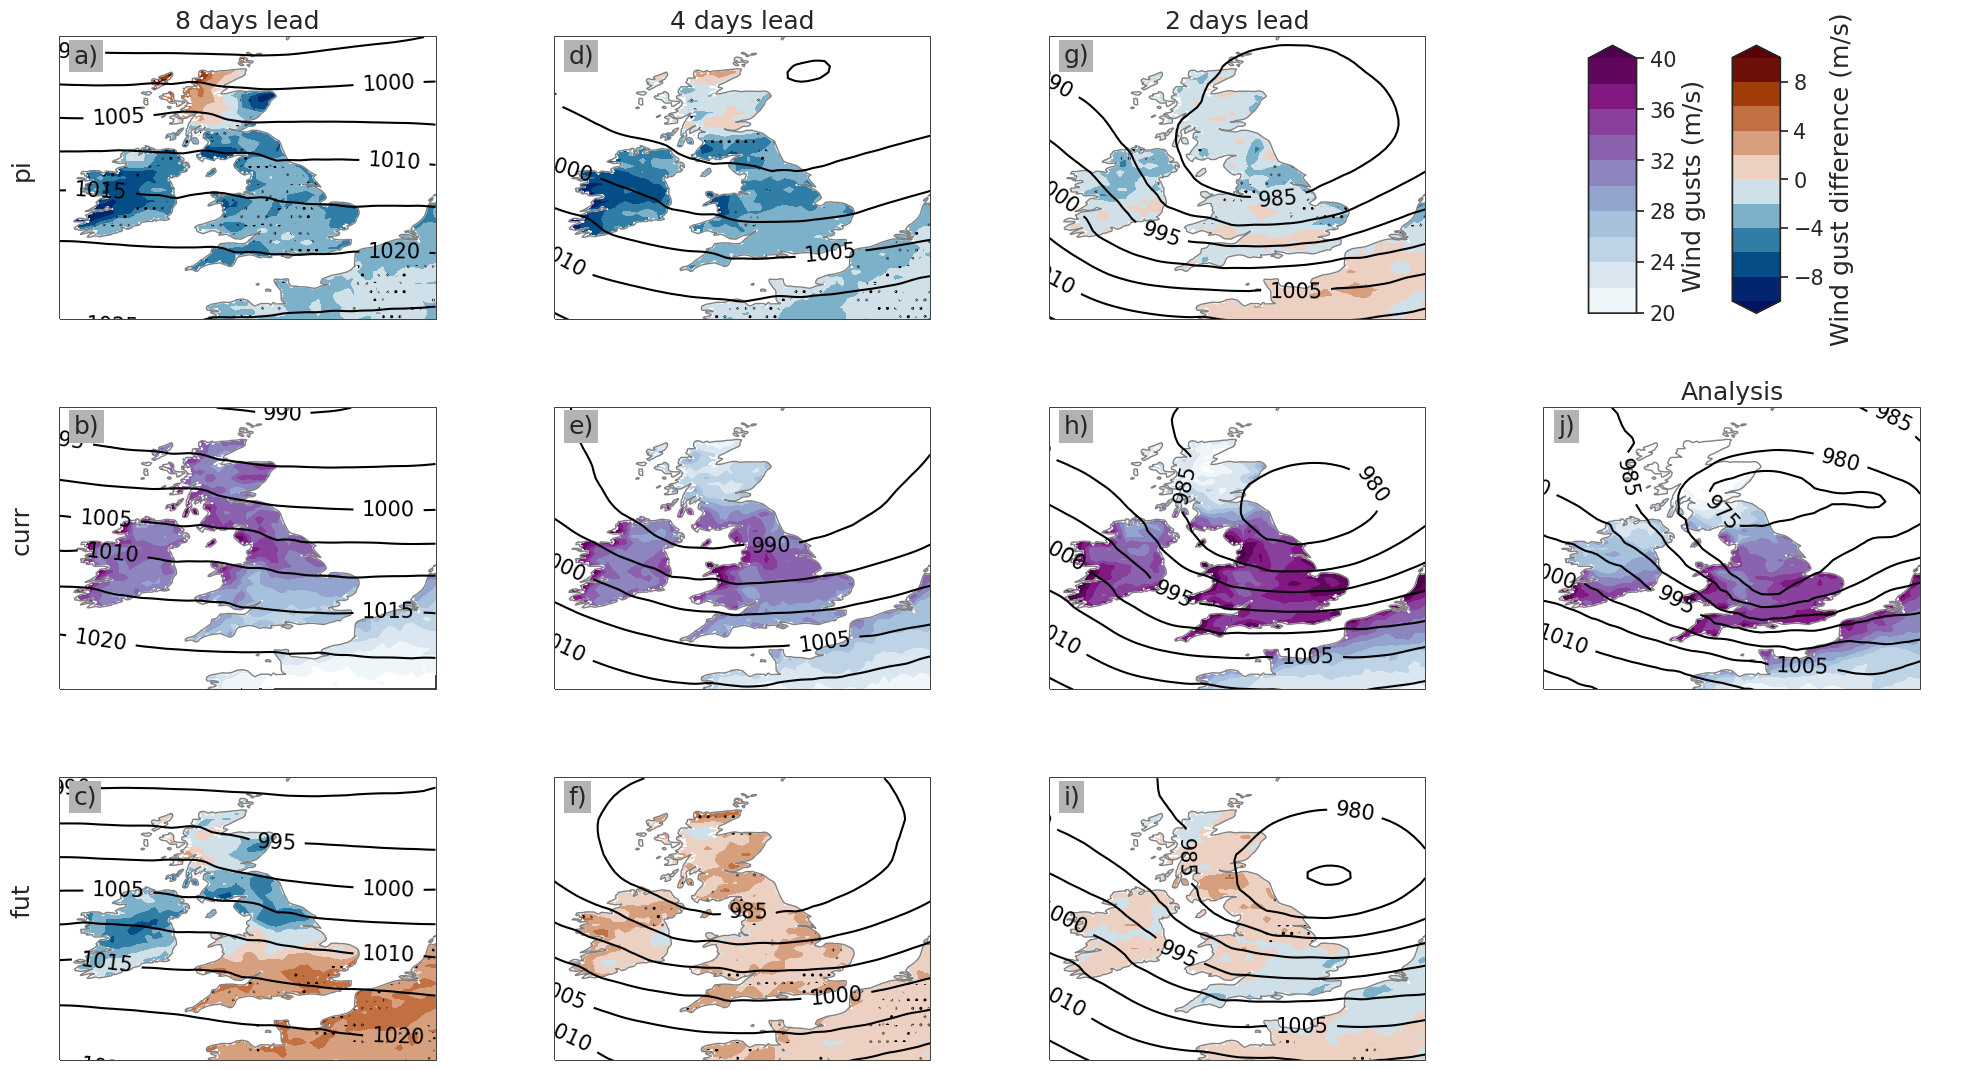

In [76]:
# figure and map setup
fs = 18
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 960

fg10_min = 20
fg10_max = 40

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['8 days lead', '4 days lead', '2 days lead']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)']

# EPS data ------------------    
latitude = mean_pres_eps['2022-02-10']['pi'].latitude.values
longitude = mean_pres_eps['2022-02-10']['pi'].longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (mean_pres_eps[inidate][experiment]/100).msl.values

        if experiment in ['pi', 'incr']:  # plot differencefor counterfactual scenarios
            fg10_vals = (maximum_gusts_eps[inidate][experiment] - maximum_gusts_eps[inidate]['curr']).fg10.values
        else: 
            fg10_vals = maximum_gusts_eps[inidate][experiment].fg10.values

        ax = plt.subplot(3,4, i+1+e*4,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # fg10 as shading
        if experiment =='curr':
            clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                            transform=projection, zorder = 10, extend = 'max')
        else: 
            clevs_fg10 = np.linspace(-10, 10, 11)
            cf_diff = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 5)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # subplot label
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, labels[i*3+e], transform=ax.transAxes + trans,
            fontsize=fs, verticalalignment='top', 
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0), zorder=18)
    
        # hatching for significance
        if experiment in ['pi', 'incr']:
            sign = sign_test[inidate][experiment]
            ax.contourf(longitude, latitude, sign, alpha=0,hatches=[None, '..'], n_levels=2, add_colorbar=False, zorder=11)

# ERA5 or analysis data ----------------------
latitude = mean_pres_analysis.latitude
longitude = mean_pres_analysis.longitude

p_vals = (mean_pres_analysis/100).msl.values
fg10_vals = maximum_gusts_forecast.fg10.values
ax = plt.subplot(3,4,8,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

# fg10 as shading
clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 5)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("Analysis", size = fs)

trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax.text(0.0, 1.0, labels[-1], transform=ax.transAxes + trans,
    fontsize=fs, verticalalignment='top', 
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0), zorder=18)


# Other figure settings -----------------
ax = plt.subplot(3,4,4)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='Wind gusts (m/s)', extend = 'max', shrink=0.8)
cbar.set_label(label='Wind gusts (m/s)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.5, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='Wind gusts (m/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='Wind gust difference (m/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(0.01, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(0.01, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(0.01, 0.15, 'fut', rotation='vertical', size=fs)
plt.tight_layout()

# if composite:
#     plt.savefig('figures/PAPER1_max_gusts_'+area_for_percentiles+'.png')
#     plt.savefig('figures/PAPER1_max_gusts_'+area_for_percentiles+'.pdf')
#     plt.savefig('figures/PAPER1_max_gusts_'+area_for_percentiles+'.eps')

# if not composite:
#     plt.savefig('figures/PAPER1_max_gusts_local'+str(threshold*100)+'perc.png')
#     plt.savefig('figures/PAPER1_max_gusts_local'+str(threshold*100)+'perc.pdf')
#     plt.savefig('figures/PAPER1_max_gusts_local'+str(threshold*100)+'perc.eps')